In [28]:
%matplotlib inline

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [30]:
torch.cuda.is_available()

True

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [32]:
import os
from typing import Tuple
import torchaudio
from torch.utils.data import Dataset
from torch import Tensor
from pathlib import Path

def load_audio_item(filepath: str, path: str, label_name: str) -> Tuple[Tensor, int, str, str]:
    relpath = os.path.relpath(filepath, path)
    label, filename = os.path.split(relpath)
    if label_name is not None:
        label = label_name
    waveform, sample_rate = torchaudio.load(filepath, normalize = True, channels_first = True)
    return waveform, sample_rate, label, filename

class AudioFolder(Dataset):
    """Create a Dataset from Local Files.
    Args:
        path (str): Path to the directory where the dataset is found or downloaded.
        suffix (str) : Audio file type, defaulted to ".WAV".
        pattern (str) : Find pathnames matching this pattern. Defaulted to "*/*" 
        new_sample_rate (int) : Resample audio to new sample rate specified.
        spectrogram_transform (bool): If `True` transform the audio waveform and returns it  
        transformed into a spectrogram tensor.
        label (str): The label is pulled from the folders in the path, this allows you to statically
        define the label string.
    """


    def __init__(
            self,
            path: str,
            suffix: str = ".wav",
            pattern: str = "*/*",
            new_sample_rate: int = None,
            spectrogram_transform: bool = False,
            label: str = None
                    ):

        self._path = path
        self._spectrogram_transform = spectrogram_transform
        self._new_sample_rate = new_sample_rate
        self._label = label

        walker = sorted(str(p) for p in Path(self._path).glob(f'{pattern}{suffix}'))
        self._walker = list(walker)

    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, str]:
        """Load the n-th sample from the dataset.
        Args:
            n (int): The index of the file to be loaded
        Returns:
            tuple: ``(waveform, sample_rate, label, filename)``
        """
        fileid = self._walker[n]

        waveform, sample_rate, label, filename =  load_audio_item(fileid, self._path, self._label)

        if self._new_sample_rate is not None:
            waveform = torchaudio.transforms.Resample(sample_rate, self._new_sample_rate)(waveform)
            sample_rate = self._new_sample_rate
        if self._spectrogram_transform is True:
            # waveform = torchaudio.transforms.MelSpectrogram()(waveform)
            # waveform = torch.flatten(torchaudio.transforms.Spectrogram()(waveform), start_dim=0, end_dim=1) 
            waveform = torchaudio.transforms.Spectrogram(n_fft = 1024)(waveform)
           

        return waveform, sample_rate, label, filename
    

    def __len__(self) -> int:
        return len(self._walker)

In [33]:
db = AudioFolder(path='./records_by_classes/', spectrogram_transform=True)

In [34]:
train_set, test_set = torch.utils.data.random_split(db, [0.7, 0.3])

In [35]:
spectrogram, sample_rate, label, file_name = train_set[0]
spectrogram.shape

torch.Size([1, 513, 469])

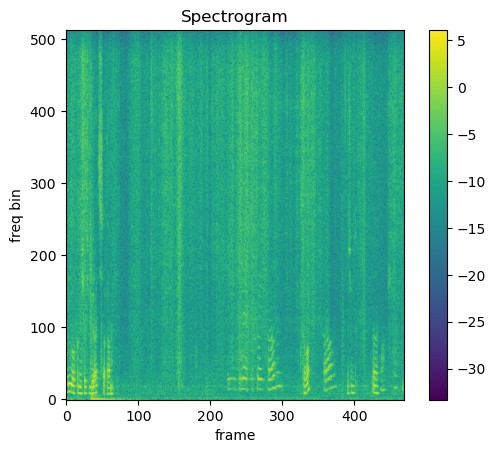

In [36]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Spectrogram")
axs.set_ylabel("freq bin")
axs.set_xlabel("frame")
axs.set_aspect('equal', adjustable='box')
im = axs.imshow(torch.flatten(spectrogram, start_dim=0, end_dim=1).log2().numpy(), origin="lower")
fig.colorbar(im, ax=axs)
plt.show(block=False)

In [37]:
# transform = torchaudio.transforms.MelSpectrogram(sample_rate)
# mel_specgram = transform(spectrogram)
# mel_specgram.shape

In [38]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['bad', 'good', 'neutral']

To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [39]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [40]:
def collate_fn(batch):
    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_set, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=collate_fn,
    batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_set, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=collate_fn,
    batch_size=batch_size)


## Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific model_itecture is modeled after the M5 network model_itecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [41]:
class CNN_audio_net(nn.Module):
    def __init__(self, n_output):
        super(CNN_audio_net, self).__init__()
        self.n_output = n_output
        # self.Fc_features = 201
        self.C1 = nn.Conv2d(1,32,5,padding=1)
        self.C2 = nn.Conv2d(32,32,5,padding=1)
        self.C3 = nn.Conv2d(32,64,5,padding=1)
        self.C4 = nn.Conv2d(64,64,5,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.maxpool2 = nn.MaxPool2d((1,2),(1,2))
        
        self.fc1 = nn.Linear(182784,128)
        self.fc2 = nn.Linear(128,self.n_output)
        self.dropout = nn.Dropout(0.25)
        self.Bat1 = nn.BatchNorm1d(128)

        self.logSM = nn.LogSoftmax(dim=1)


    def forward(self,x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.BN1(self.C1(x)))
        x = self.maxpool1(F.relu(self.BN1(self.C2(x))))
        x = F.relu(self.BN2(self.C3(x)))
        x = self.maxpool1(F.relu(self.BN2(self.C4(x))))
        x = F.relu(self.BN2(self.C4(x)))
        x = self.maxpool1(F.relu(self.BN2(self.C4(x))))
        x = F.relu(self.BN2(self.C4(x)))
        x = F.relu(self.BN3(self.C4(x)))
        # flatten image input
        x = self.dropout(torch.flatten(x, 1))
        # add dropout layer
        x =  self.dropout(self.fc1(x))
        # add 1st hidden layer, with relu activation function
        # add dropout layer
        # add 2nd hidden layer, with relu activation function
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        x = self.logSM(x)
        
        return x
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training and Testing

In [42]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target, *_) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)

        # print(output)
        # print(output.shape)
        # print(target)
        # loss = F.nll_loss(output.squeeze(), target)
        loss = F.cross_entropy(output.squeeze(), target)
        # print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch}\t[{(batch_idx * len(data)):5.0f}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):3.0f}%)]\tLoss: {loss.item():.4f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [43]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f" Test Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")
    return accuracy

In [44]:
# log_interval = 20
# n_epoch = 30

# pbar_update = 1 / (len(train_loader) + len(test_loader))
# losses = []
# accuracies = []

# model = CNN_audio_net(n_output=len(labels))
# model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)  # reduce the learning after 4 epochs by a factor of 10
# # The transform needs to live on the same device as the model and the data.
# # transform = transform.to(device)
# with tqdm(total=n_epoch, 
#           bar_format = "{desc}: {percentage:.2f}%|{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}]",
#           colour = 'GREEN',
#           ) as pbar:
#     for epoch in range(1, n_epoch + 1):
#         train(model, epoch, log_interval)
#         accuracy_step = test(model, epoch)
#         accuracies.append(accuracy_step)
#         scheduler.step()


In [45]:
# plt.plot(losses)
# plt.xlabel('batch')
# plt.ylabel('loss')
# plt.title("training loss")

In [46]:
# plt.plot(accuracies)
# plt.ylim(0, 100)
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.title("training accuracy")

In [47]:
# print(count_parameters(model))

In [56]:
from torchvision import models

model_ = models.mobilenet_v3_small(pretrained=True)

w = model_.features[0][0].weight
model_.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model_.features[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))

model_.classifier[3] = torch.nn.Linear(1280, len(labels)) 
model_.to(device)

c:\Soft\Anaconda\envs\vad-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Soft\Anaconda\envs\vad-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1520643

In [49]:
log_interval = 20
n_epoch = 30

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
accuracies = []

optimizer = optim.Adam(model_.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.3) 

with tqdm(total=n_epoch, 
          bar_format = "{desc}: {percentage:.2f}%|{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}]",
          colour = 'GREEN',
          ) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_, epoch, log_interval)
        accuracy_step = test(model_, epoch)
        accuracies.append(accuracy_step)
        scheduler.step()

0.00%|          | 0.00/30 [00:00<?]

Train Epoch: 1	[    0/103 (  0%)]	Loss: 1.0952
 Test Epoch: 1	Accuracy: 13/44 (30%)

Train Epoch: 2	[    0/103 (  0%)]	Loss: 0.9357
 Test Epoch: 2	Accuracy: 11/44 (25%)

Train Epoch: 3	[    0/103 (  0%)]	Loss: 1.0263
 Test Epoch: 3	Accuracy: 11/44 (25%)

Train Epoch: 4	[    0/103 (  0%)]	Loss: 0.6462
 Test Epoch: 4	Accuracy: 9/44 (20%)

Train Epoch: 5	[    0/103 (  0%)]	Loss: 0.7057
 Test Epoch: 5	Accuracy: 12/44 (27%)

Train Epoch: 6	[    0/103 (  0%)]	Loss: 0.5189
 Test Epoch: 6	Accuracy: 12/44 (27%)

Train Epoch: 7	[    0/103 (  0%)]	Loss: 0.3381
 Test Epoch: 7	Accuracy: 12/44 (27%)

Train Epoch: 8	[    0/103 (  0%)]	Loss: 0.2986
 Test Epoch: 8	Accuracy: 11/44 (25%)

Train Epoch: 9	[    0/103 (  0%)]	Loss: 0.2759
 Test Epoch: 9	Accuracy: 11/44 (25%)

Train Epoch: 10	[    0/103 (  0%)]	Loss: 0.7414
 Test Epoch: 10	Accuracy: 14/44 (32%)

Train Epoch: 11	[    0/103 (  0%)]	Loss: 0.2345
 Test Epoch: 11	Accuracy: 16/44 (36%)

Train Epoch: 12	[    0/103 (  0%)]	Loss: 0.6338
 Test Epoch: 1

Text(0.5, 1.0, 'training loss')

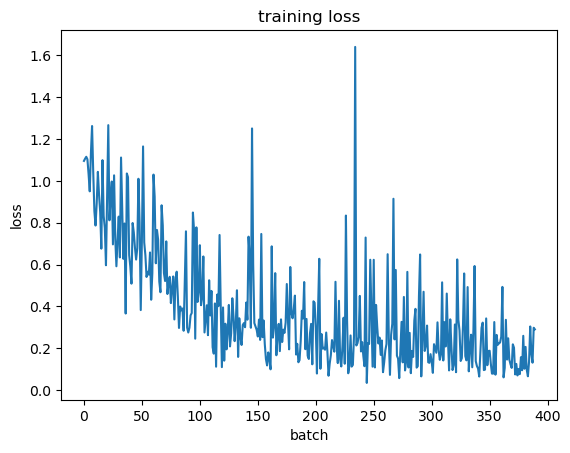

In [50]:
plt.plot(losses)
plt.xlabel('batch')
plt.ylabel('loss')
plt.title("training loss")

Text(0.5, 1.0, 'training accuracy')

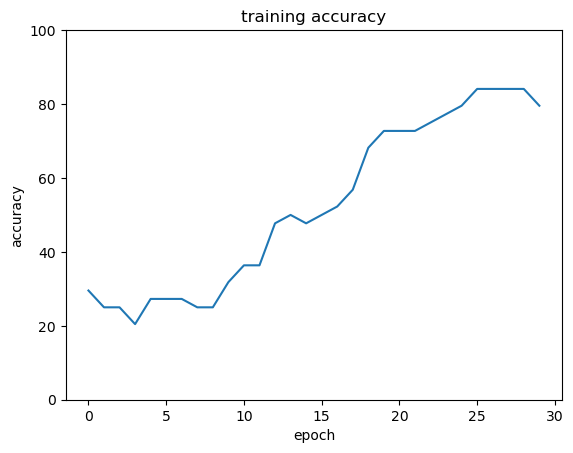

In [51]:
plt.plot(accuracies)
plt.ylim(0, 100)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("training accuracy")

In [52]:
print(count_parameters(model_))

4205587


[1 0 1 2 0 1 2 1 0 2 2 1 0 1 2 1 1 0 1 1 1 2 2 2 2 0 1 1 1 1 1 1 1 0 1 2 1
 1 1 2 1 1 1 2]
[1 0 1 2 0 1 2 1 0 1 0 2 0 1 2 1 2 2 1 1 1 2 2 2 2 2 1 1 1 2 1 1 2 0 1 2 1
 1 1 2 1 1 2 2]
              precision    recall  f1-score   support

        good       0.83      0.71      0.77         7
         bad       0.95      0.80      0.87        25
     neutral       0.59      0.83      0.69        12

    accuracy                           0.80        44
   macro avg       0.79      0.78      0.78        44
weighted avg       0.83      0.80      0.80        44



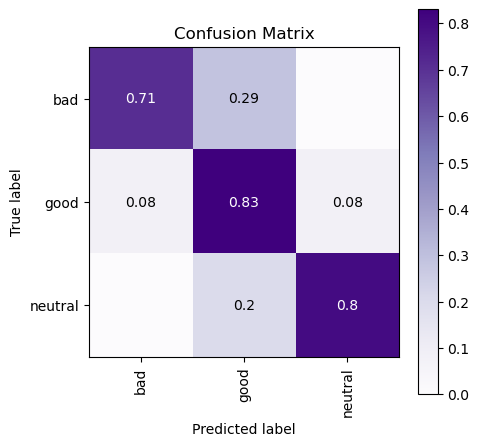

In [53]:
target_classes = {0:"bad", 1:"neutral", 2:"good"}
import numpy as np

def print_results(Y_actual, Y_preds, target_names):
    from sklearn.metrics import confusion_matrix, classification_report
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    
    tcs = ["good", "bad", "neutral"]
    print(classification_report(Y_actual, Y_preds, target_names=tcs))
    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def make_predictions(model):
    Y_shuffled, Y_preds = [], []

    model.eval()
    correct = 0

    with torch.no_grad():
       for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
  
        predicted_label = model(data)
        
        Y_preds.append(predicted_label)
        Y_shuffled.append(target)
            
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)
    
    a = F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

    return Y_shuffled.detach().cpu().numpy(), a


Y_actual, Y_preds = make_predictions(model_)
print(Y_actual)
print(Y_preds)
print_results(Y_actual, Y_preds, target_classes)

In [55]:
def save_model(model, path, name):
    model_scripted = torch.jit.script(model)
    model_scripted.save(path + name)

# save_model(model_, './audio/', 'audio_spectrogram_clsf_70.pt')